In [2]:
import pandas as pd
import numpy as np

## データの読み込み

In [3]:
train = pd.read_csv("train.tsv", delimiter='\t', low_memory=True)
test = pd.read_csv("test.tsv", delimiter='\t', low_memory=True)

## 前処理・特徴量エンジニアリング
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「７」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えています。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなります。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられています。

In [4]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### trainの統計量を表示　transposeで行と列を入れ替え

* train_id：uniqueが0で重複無し
* name：uniqueが多く、商品名が重複している
* brand_name：nameと同じで半分ほど重複している
* price：mean(平均値)が26.7ドル　最小値が0ドル、最大値が2009ドル
* item_description：top(最頻値)はNo description yet(商品説明なし)が82,489個で全体の5.6%

In [5]:
train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_id,1482535.0,NaN,NaN,NaN,741267.0,427971.135004,0.0,370633.5,741267.0,1111900.5,1482534.0
name,1482535,1225273,Bundle,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_condition_id,1482535.0,NaN,NaN,NaN,1.90738,0.903159,1.0,1.0,2.0,3.0,5.0
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand_name,849853,4809,PINK,54088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1482535.0,NaN,NaN,NaN,26.737516,38.586066,0.0,10.0,17.0,29.0,2009.0
shipping,1482535.0,NaN,NaN,NaN,0.447274,0.497212,0.0,0.0,0.0,1.0,1.0
item_description,1482529,1281425,No description yet,82489,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 変数の関係を見る
## Price

In [6]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

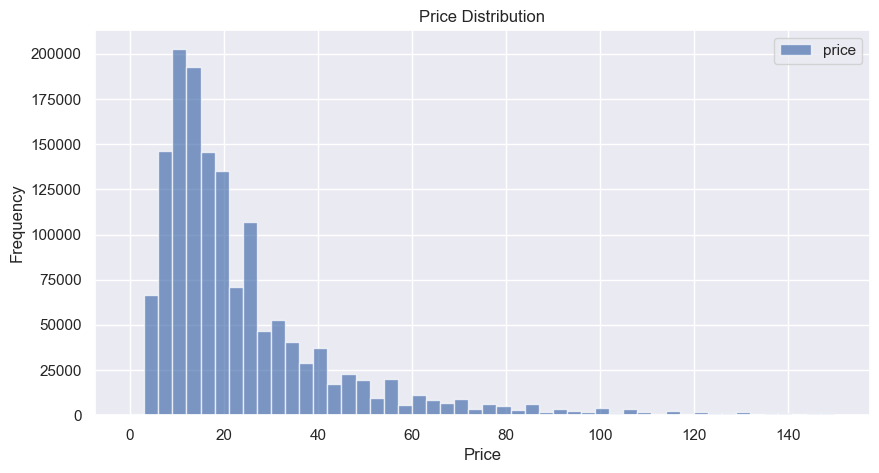

In [7]:
#priceをヒストグラムで表示
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 5))
plt.hist(train.price, bins=50, range=[0, 150], alpha=0.7, color='b', label='price')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()

### 分布が左に偏っているため対数変換して、正規分布にする

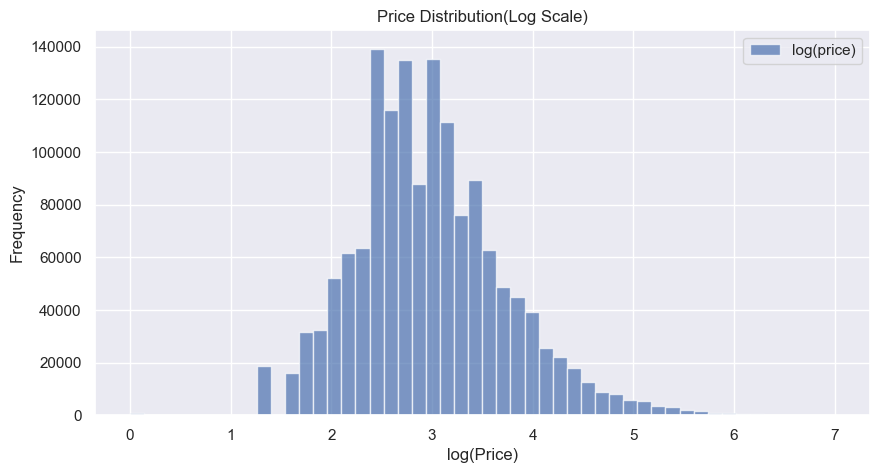

In [8]:
#priceを対数変換してヒストグラムで表示
plt.figure(figsize=(10, 5))
plt.hist(np.log1p(train.price), bins=50, range=[0, 7], alpha=0.7, color='b', label='price')
plt.title('Price Distribution(Log Scale)')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.legend(['log(price)'])

## Shipping

#### 商品の送料の半分以上（55%）は売り手が負担

In [9]:
#shippingの割合を表示 1が販売者負担、0が購入者負担
train.shipping.value_counts() / len(train)

shipping
0    0.552726
1    0.447274
Name: count, dtype: float64

#### 追加の送料分があるから、送料別(買い手負担、赤色のグラフ)の方が安い

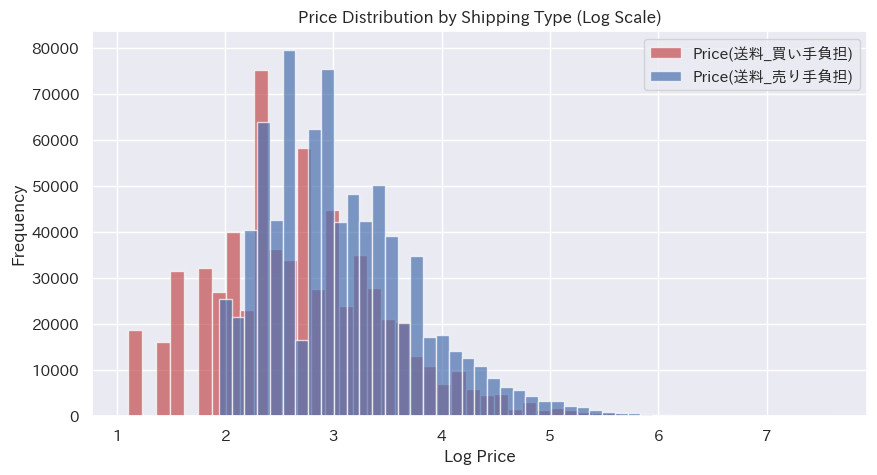

In [10]:
#shippingが売り手負担かどうかでpriceがどう変わるかを確認
plt.figure(figsize=(10, 5))

shipping_fee_by_seller = train.loc[train.shipping==1, 'price']
shipping_fee_by_buyer = train.loc[train.shipping==0, 'price']

# 価格データを対数変換し、0を除外
log_shipping_fee_by_seller = np.log(shipping_fee_by_seller[shipping_fee_by_seller > 0])
log_shipping_fee_by_buyer = np.log(shipping_fee_by_buyer[shipping_fee_by_buyer > 0])

import japanize_matplotlib # 日本語化
plt.hist(log_shipping_fee_by_seller, bins=50, alpha=0.7, color='r', label='Price(送料_買い手負担)')
plt.hist(log_shipping_fee_by_buyer, bins=50, alpha=0.7, color='b', label='Price(送料_売り手負担)')

plt.title('Price Distribution by Shipping Type (Log Scale)')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.legend()

## category_name

女性用の服、美容品が多い

In [11]:
#Top 10のカテゴリを表示 
train.category_name.value_counts()[:10] #[:10]で上位10件を表示 [10:]で下位10件を表示

category_name
Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Name: count, dtype: int64

### general_category, sub_category1, sub_category2 に3等分する

In [12]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") #categoryがない場合はNo Labelを返す

train['general_cat'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


### testデータも同様に3等分

In [13]:
test['general_cat'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))

### 7つのメインカテゴリがあり、女性向けの商品が多い

Text(0, 0.5, 'general category')

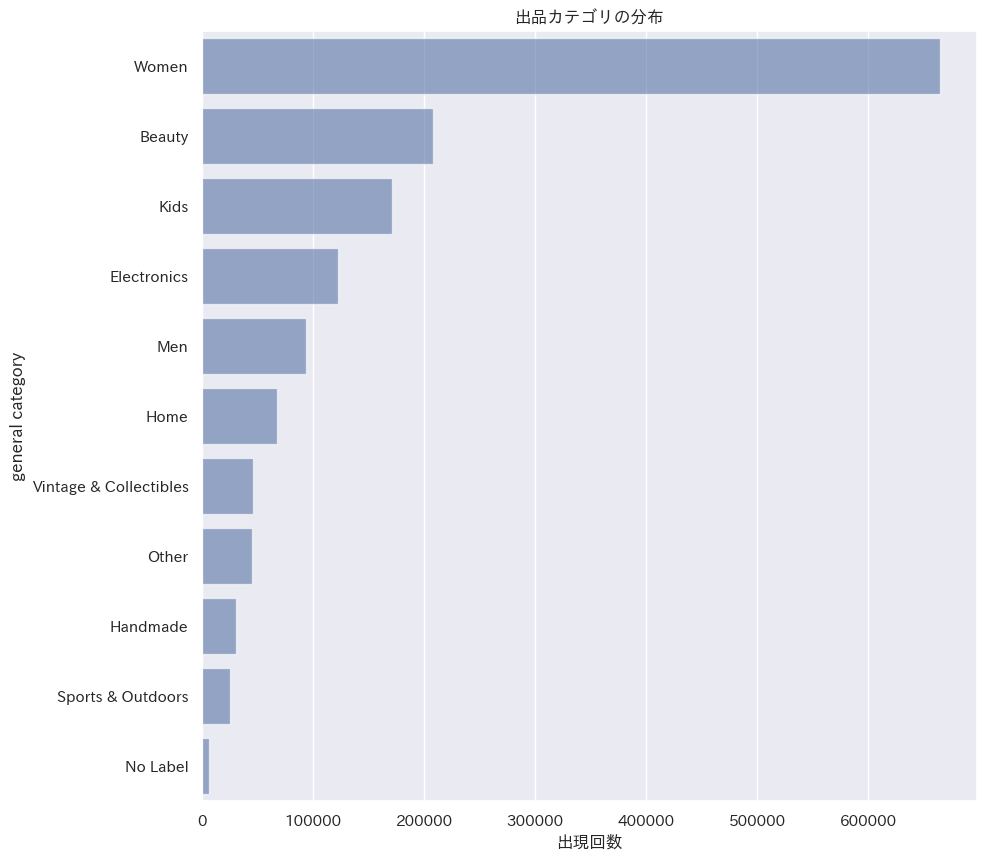

In [14]:
x_general = train['general_cat'].value_counts().index.values.astype('str') #カテゴリ名
y_general = train['general_cat'].value_counts().values #カテゴリの出現回数
pct = [("%.2f"%(v*100))+"%"for v in (y_general/len(train))] #パーセンテージ

plt.figure(figsize=(10,10))
sns.barplot(x=y_general, y=x_general, alpha=0.6)
plt.title("出品カテゴリの分布")
plt.xlabel("出現回数")
plt.ylabel("general category")

### サブカテゴリのうち、Apparel, Make, Topsなどが多い

Text(0, 0.5, 'sub category')

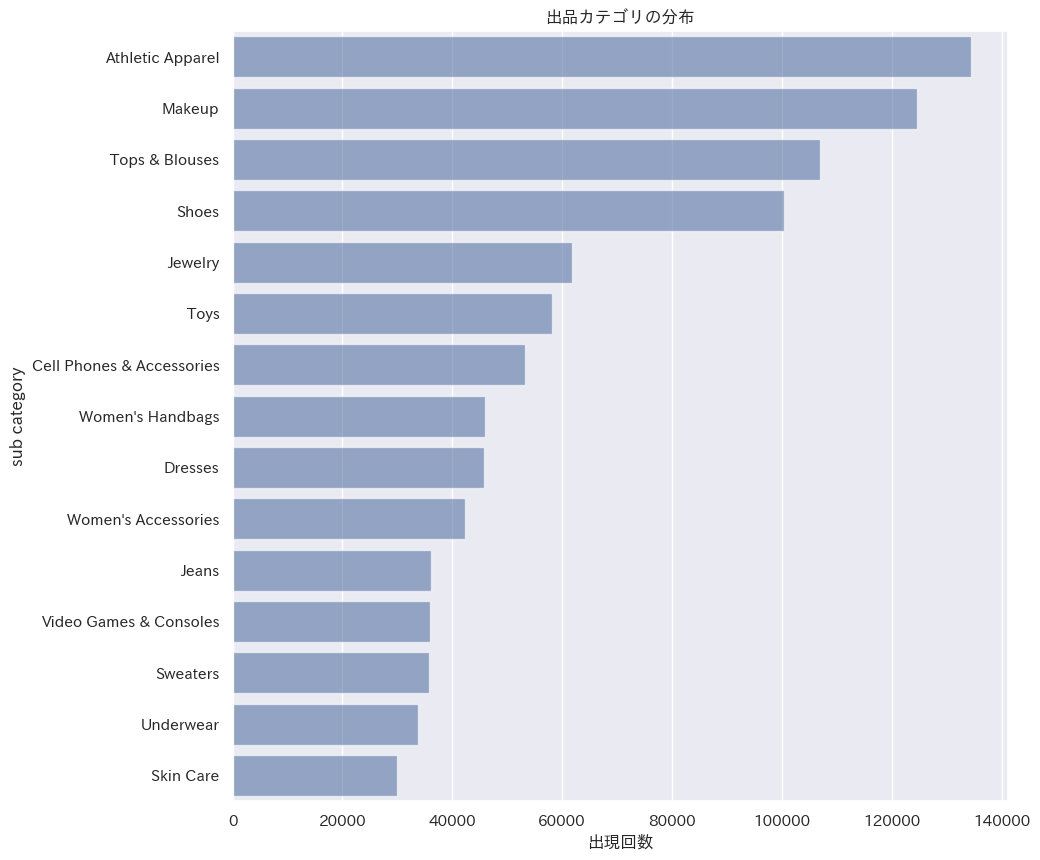

In [15]:
x_sub = train['sub_cat1'].value_counts().index.values.astype('str')[:15]
y_sub = train['sub_cat1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y_sub/len(train))][:15]

plt.figure(figsize=(10,10))
sns.barplot(x=y_sub, y=x_sub, alpha=0.6)
plt.title("出品カテゴリの分布")
plt.xlabel("出現回数")
plt.ylabel("sub category")

object(文字列)のままだと学習ができないため、カテゴリ変数にする

In [16]:
#general_cat, sub_cat1, sub_cat2をカテゴリ変数に変換
train['general_cat'] = train['general_cat'].astype('category')
train['sub_cat1'] = train['sub_cat1'].astype('category')
train['sub_cat2'] = train['sub_cat2'].astype('category')
train.dtypes

train_id                int64
name                   object
item_condition_id       int64
category_name          object
brand_name             object
price                 float64
shipping                int64
item_description       object
general_cat          category
sub_cat1             category
sub_cat2             category
dtype: object

## brand_name, item_name


商品説明が長いほど、価格が高くなると予想。a,the,句読点,3文字未満の単語を全て削除

Macだとアーキテクチャの違いでimportできない
https://zenn.dev/kubomi/articles/311856ee3f7daa

In [17]:
# import re
# import string
# import nltk
# from nltk.stem.porter import *
# from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.corpus import stopwords
# stop_words_set = set(stopwords.words('english'))
# from sklearn.feature_extraction import stop_words

# from collections import Counter
# from wordcloud import WordCloud
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

# def wordCount(text):
#     # convert to lower case and strip regex
#     try:
#          # convert to lower case and strip regex
#         text = text.lower()
#         regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
#         txt = regex.sub(" ", text)
#         # tokenize
#         # words = nltk.word_tokenize(clean_txt)
#         # remove words in stop words
#         words = [w for w in txt.split(" ") \
#                  if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
#         return len(words)
#     except: 
#         return 0

## 単語量のみを数値に変換
詳細を書けば書くほど価格が上がるという安直な予想
https://qiita.com/kawanago_py/items/d93e59d795d504ce5cba

### name, item_descriptionの処理

In [18]:
#item_description：文章量に含まれる単語数をカウント
def words_count_description(text):
  if text == "No description yet":
    return 0
  else:
    return len(str(text).split())

train["words_of_description"] = train["item_description"].map(words_count_description)

#name：含まれる単語量をカウント
def words_count_name(text):
  if text == "NaN":
    return 0
  else:
    return len(str(text).split())

train["words_of_name"] = train["name"].map(words_count_name)

### brand_nameの処理
まずはシンプルにブランドの登録がある場合は1、
ない場合は0として処理を行なった。

In [19]:
#brand_name：ある場合は1、ない場合は0に変換
train["is_brand_name"] = np.where(train["brand_name"].isnull(),0,1)

In [20]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,words_of_description,words_of_name,is_brand_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,0,7,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,36,4,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,29,2,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,32,3,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,5,4,0


### 欠損値の処理

In [21]:
train.isnull().sum()

train_id                     0
name                         0
item_condition_id            0
category_name             6327
brand_name              632682
price                        0
shipping                     0
item_description             6
general_cat                  0
sub_cat1                     0
sub_cat2                     0
words_of_description         0
words_of_name                0
is_brand_name                0
dtype: int64

In [22]:
#欠損値を処理
train["category_name"].fillna("NaN", inplace=True)
train["brand_name"].fillna("None", inplace=True)
train["item_description"].fillna("No description yet", inplace=True)

/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_16618/1183898684.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["category_name"].fillna("NaN", inplace=True)
/var/folders/nd/899zv4_x0794899fclq_b17c0000gn/T/ipykernel_16618/1183898684.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

　先ほど、priceは対数の方が均等なグラフになったため変換

In [23]:
target = np.log1p(train["price"].values) 

## ダミー変数化
* item_condition_id
* shipping
* brand_name
pandasのget_dummiesを使用し、ダミー変数化を行う。

In [24]:
train.name = train.name.astype("category")
train.category_name = train.category_name.astype("category")
train.brand_name = train.brand_name.astype("category")
train.item_description = train.item_description.astype("category")

In [25]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,words_of_description,words_of_name,is_brand_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet,Men,Tops,T-shirts,0,7,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,36,4,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,29,2,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,32,3,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,None,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,5,4,0


In [26]:
train.dtypes

train_id                   int64
name                    category
item_condition_id          int64
category_name           category
brand_name              category
price                    float64
shipping                   int64
item_description        category
general_cat             category
sub_cat1                category
sub_cat2                category
words_of_description       int64
words_of_name              int64
is_brand_name              int64
dtype: object

## モデルの作成と学習

In [27]:
#general_cat, sub_cat1, sub_cat2を除外
train = train.drop(["general_cat", "sub_cat1", "sub_cat2"], axis=1)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.3)

In [30]:
print("Lasso学習開始")
from sklearn.linear_model import Lasso
model_Lasso = Lasso()
model_Lasso.fit(X_train, y_train)

print("Lasso")
print(f"train_score:{model_Lasso.score(X_train, y_train)}")
print(f"val_score:{model_Lasso.score(X_val, y_val)}")

print("ElasticNet学習開始")
from sklearn.linear_model import ElasticNet
model_Ela = ElasticNet()
model_Ela.fit(X_train, y_train)

print("")
print("ElasticNet")
print(f"train_score:{model_Ela.score(X_train, y_train)}")
print(f"val_score:{model_Ela.score(X_val, y_val)}")

print("Ridge学習開始")
from sklearn.linear_model import Ridge
model_Ridge = Ridge()
model_Ridge.fit(X_train, y_train)

print("")
print("Ridge")
print(f"train_score:{model_Ridge.score(X_train, y_train)}")
print(f"val_score:{model_Ridge.score(X_val, y_val)}")


Lasso学習開始


ValueError: could not convert string to float: 'Breyer Stablemate Body'